Demonstrate how `QuantToolkit` can solve problems that the standard TFL quantizer can not do with `isnet` (http://go/arxiv/2108.12382).

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import skimage
import tensorflow as tf
from tensorflow.python.platform import gfile

In [ ]:
# @title Preprocess/postprocess utils (unrelated to quantization) { display-mode: "form" }
MODEL_INPUT_HW = (1024, 1024)

def make_channels_first(image):
  image = tf.transpose(image, [2, 0, 1])
  image = np.expand_dims(image, axis=0)
  return image

def preprocess_image(file_path):
  image = skimage.io.imread(file_path)
  image = tf.image.resize(image, MODEL_INPUT_HW).numpy().astype(np.float32)
  image = image / 255.0
  return make_channels_first(image)

def preprocess_image_ai_edge_torch(test_image_path):
  image = Image.open(test_image_path)
  test_image = np.array(image.resize(MODEL_INPUT_HW, Image.Resampling.BILINEAR))
  test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
  return test_image

def run_inference(image, tflite_model):
  """Get segmentation mask of the image."""
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  interpreter.set_tensor(input_details["index"], image)
  interpreter.invoke()

  output_details = interpreter.get_output_details()
  # ai_edge_torch converted model has only one output but
  # ONNX converted model has 5.
  output_index = 5 if len(output_details) > 1 else 0
  outputs = []
  for detail in output_details:
    outputs.append(interpreter.get_tensor(detail["index"]))
  mask = tf.squeeze(outputs[output_index])
  # Min-max normalization.
  tf_min = np.min(mask)
  tf_max = np.max(mask)
  mask = (mask - tf_min) / (tf_max - tf_min)
  # Scale [0, 1] -> [0, 255].
  mask = (mask * 255)
  return mask


def draw_segementation(image, float_mask, quant_mask, info):
  _, ax = plt.subplots(1, 3, figsize=(15, 10))

  ax[0].imshow(np.array(image))
  ax[1].imshow(np.array(float_mask), cmap="gray")
  ax[2].imshow(np.array(quant_mask), cmap="gray")

  ax[1].set_title("Image")
  ax[1].set_title("Float Mask")
  ax[2].set_title("Quant Mask: {}".format(info))

  plt.show()

def save_tfl_model(model_content, save_path):
  with gfile.Open(save_path, "wb") as f:
    f.write(model_content)
  print("model saved to: {}".format(save_path))




In [ ]:
# @title file paths
BASE_SAVE_PATH = '/cns/py-d/home/tensorflow-mobile-eng/rewu/isnet_playground/'
TEST_IMAGE_PATH = os.path.join(BASE_SAVE_PATH, "source_model/","input_image.jpg")
SAVED_MODEL_PATH = os.path.join(BASE_SAVE_PATH, "source_model/","isnet_saved_model")
AI_EDGE_TORCH_CONVERTED_MODEL_PATH = os.path.join(BASE_SAVE_PATH, "source_model/","torch_isnet.tflite")

In [ ]:
# @title test image
!fileutil cp {TEST_IMAGE_PATH} ./input_image.jpg # copy the test image to local
image_path = os.path.basename('./input_image.jpg')
image = Image.open(image_path)
test_image = preprocess_image(image_path)

# TFL conversion

In [ ]:
# @title Convert the float model through standard TFL converter.
tfl_converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
float_model = tfl_converter.convert()

float_model_path = "./isnet_float.tflite"
save_tfl_model(float_model, float_model_path)
save_tfl_model(float_model, BASE_SAVE_PATH + "float_model.tflite")

In [ ]:
float_mask = run_inference(test_image, float_model)

In [ ]:
# @title Quantization through TFL quantizer
tfl_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tfl_quantized_model = tfl_converter.convert()
save_tfl_model(tfl_quantized_model, BASE_SAVE_PATH + "tfl_quantized.tflite")

In [ ]:
# Run and compare.
tfl_quantized_mask = run_inference(test_image, tfl_quantized_model)
draw_segementation(image, float_mask, tfl_quantized_mask, "TFL quantized mask")

It is unclear what kind of optimizations `tfl_converter.optimizations = [tf.lite.Optimize.DEFAULT]` does to the model.


According to the doc (http://google3/third_party/tensorflow/lite/python/lite.py?l=138)

"*Default optimization strategy that quantizes model weights. Enhanced
optimizations are gained by providing a representative dataset that quantizes biases and activations as well. Converter will **DO ITS BEST** to reduce size and latency, while minimizing the loss in accuracy.*"

What does **DO ITS BEST** mean? Read this doc https://www.tensorflow.org/lite/performance/post_training_quantization.





But from our 3p partners, we know this model works fine (good quality) after quantizing with Apple CoreML. On the other hand, there is not much things we can do with standard TFL quantizatizer as quantization logics are hidden in the converter (a.k.a. **DO ITS BEST**).

Here comes the rescue from ODML Quantizer (temporary name)

# ODML Quantizer

In [ ]:
from colabtools import adhoc_import
with adhoc_import.Google3SubmittedChangelist():
  from google3.third_party.odml.model_customization.quantization.quant_toolkit import QuantToolkit

To use the `QuantToolkit`, we need to provide
* the float .tflite model.
* quantization recipe (i.e., apply quantization algorithm X on Operator Y with configuration Z).






### Weight only quantization (Apple CoreML Recipe)
We know that Apple CoreML's default quantization mode is weight-only quantization (https://apple.github.io/coremltools/docs-guides/source/data-free-quantization.html), so lets use this as our recipe:

In [ ]:
# Initialize with float .tflite and quantization recipe.
recipe_path = '/cns/py-d/home/tensorflow-mobile-eng/rewu/isnet_playground/default_recipes/conv_weight_only_recipe.json'
qt = QuantToolkit(
    float_model_path=float_model_path, quantization_recipe_path=recipe_path
)
# Quantize.
quantization_result = qt.quantize()
# Side by side comparison with the float model.
quantized_mask = run_inference(test_image, quantization_result.quantized_model)
draw_segementation(image, float_mask, quantized_mask, "ODML WEIGHT_ONLY")
# Quantization results are savable
quantization_result.save(
    save_folder=BASE_SAVE_PATH, model_name='asym_weight_only'
)

Followings are step by step explainations. First, we have a prebaked quantization recipe.

In [ ]:
import json
with gfile.Open(recipe_path) as json_file:
  recipe = json.load(json_file)
recipe

Here the recipe means: apply post training quantization (`ptq`) for all `CONV_2D` ops under layers satisfying regex `.*` (i.e., all layers). We want the weights of these `CONV_2D` to be quantized as int8, asymmetric, channel_wise, and the execution mode as `Weight_only`.


`quantization_result` has two components
* quantized tflite model (in bytearray) and
* the corresponding quantization recipe

When we save, we will always save the pair so users know how the model is quantized.

In [ ]:
quantization_result.recipe

In [ ]:
type(quantization_result.quantized_model)

In [ ]:
# Quantization results are savable
quantization_result.save(
    save_folder='./', model_name='asym_weight_only'
)
!ls -l ./asym_weight_only/

### Debug TFLite quantizer
We know that TFL quantizer's default quantization mode is weight-only quantization (read https://www.tensorflow.org/lite/performance/quantization_spec carefully), so lets use this as our recipe:

In [ ]:
# Change to ai_edge_torch.convert() produced .tflite for better visualization (model above is from ONNX).
# This model is almost the same as the converted model above, but can be better visualized through Model Explorer.
float_model_path = './torch_isnet.tflite'
!fileutil cp {AI_EDGE_TORCH_CONVERTED_MODEL_PATH} {float_model_path}
test_image = preprocess_image_ai_edge_torch(image_path)
with gfile.Open(float_model_path, "rb") as f:
  float_model = f.read()
float_mask = run_inference(test_image, float_model)

In [ ]:
recipe_path = '/cns/py-d/home/tensorflow-mobile-eng/rewu/isnet_playground/default_recipes/conv_drq_recipe.json'
qt = QuantToolkit(
    float_model_path=float_model_path, quantization_recipe_path=recipe_path
)
quantization_result = qt.quantize()

In [ ]:
quantization_result.recipe

Here the recipe means: apply post training quantization (`ptq`) for all `CONV_2D` ops under layers satisfying regex `.*` (i.e., all layers). We want the weights of these `CONV_2D` to be quantized as int8, symmetric, channel_wise, and the execution mode as `DRQ` (dynamic range quantization).


In [ ]:
quantized_mask = run_inference(test_image, quantization_result.quantized_model)
draw_segementation(image, float_mask, quantized_mask, "ODML DRQ")

WHY????

"*Default optimization strategy that quantizes model weights. Enhanced optimizations are gained by providing a representative dataset that quantizes biases and activations as well. Converter will **DO ITS BEST** to reduce size and latency, while minimizing the loss in accuracy.*"

It turns out that **DO ITS BEST**  here means if the conv2d filter (weight) has only one channel, do not quantize it (not documented).

But with the `QuantToolkit`, we can do tensor by tensor comparison to debug:


In [ ]:
# @title Debug through Model Explorer (visualization)
"""Warning: qt.compare requires a lot of memory (need optimization).

Please make sure the colab kernel has a lot of memory.
"""
# tensor by tensor comparison (float vs. quantized) using median_diff_ratio
# as the metric (i.e., mdr = abs(float_tensor - dequantized_tensor)/float_tensor)
comparion_result = qt.compare(
    test_data=[[test_image]], error_metrics='median_diff_ratio'
)
# Save the results in .json format to visualize through Model Explorer
json_save_path = (
    os.path.join(BASE_SAVE_PATH, 'tensor_comparisons/')
    + 'drq_median_diff_ratio.json'
)
color_threshold = [0.05, 0.1, 0.2, 0.5, 1, 10, 100]
qt.save_comparison_result(
    comparion_result, json_save_path, color_threshold=color_threshold
)

Load `drq_median_diff_ratio.json` on top of the `.tflite` using `Model Explorer` (https://graph-visualizer.corp.google.com) to see how errors propagate through the model.

Using [Model Explorer](http://graph-visualizer/?data=%7B%22models%22:%5B%7B%22url%22:%22%2Fcns%2Fpy-d%2Fhome%2Ftensorflow-mobile-eng%2Frewu%2Fisnet_playground%2Fsource_model%2Ftorch_isnet.tflite%22,%22adapterId%22:%22builtin_tflite_flatbuffer%22%7D%5D,%22nodeData%22:%5B%22%2Fcns%2Fpy-d%2Fhome%2Ftensorflow-mobile-eng%2Frewu%2Fisnet_playground%2Ftensor_comparisons%2Fdrq_median_diff_ratio.json%22,%22%2Fcns%2Fpy-d%2Fhome%2Ftensorflow-mobile-eng%2Frewu%2Fisnet_playground%2Ftensor_comparisons%2Fdrq_wo_mixed_median_diff_ratio.json%22%5D,%22uiState%22:%7B%22paneStates%22:%5B%7B%22deepestExpandedGroupNodeIds%22:%5B%22__main__.ImageSegmentationModelWrapper%2Fmodels.isnet.ISNetDIS_model___group___%22%5D,%22selectedNodeId%22:%22%22,%22selectedGraphId%22:%22main%22,%22selectedCollectionLabel%22:%22torch_isnet.tflite%22,%22widthFraction%22:1,%22selected%22:true%7D%5D%7D%7D&renderer=webgl&show_open_in_new_tab=0), we find that the errors come from the last few layers ('RSU6','RSU7'). Lets try do not quantize them.

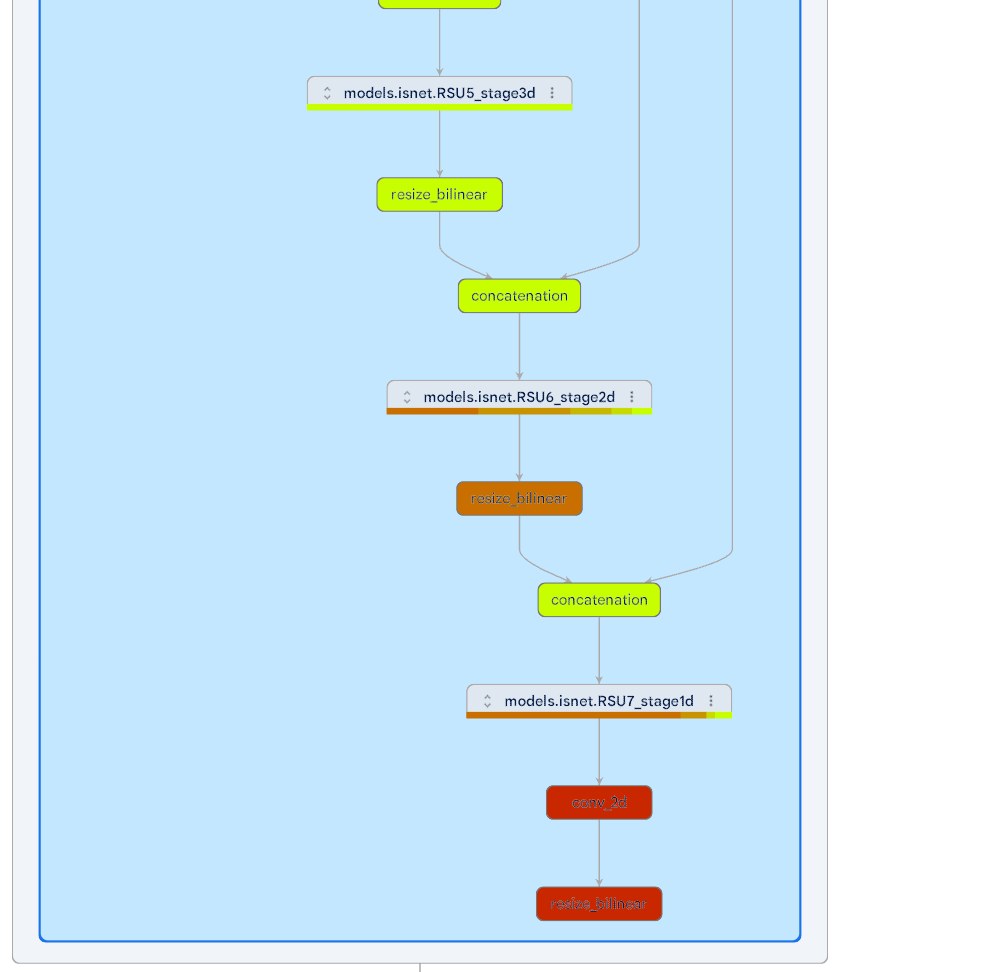

In [ ]:
# @title Selective DRQ
from google3.third_party.odml.model_customization.quantization.qtyping import TFLOperationName

qt = QuantToolkit(
    float_model_path=float_model_path, quantization_recipe_path=recipe_path
)
scopes = ['RSU6','RSU7','Conv2d_side1']
for scope in scopes:
  qt.update_quantization_recipe(
      regex=scope,
      operation_name=TFLOperationName.CONV_2D,
      algorithm_key='NO_QUANT',
  )
# qt.get_quantization_recipe()

In [ ]:
quantization_result = qt.quantize()
quantized_mask = run_inference(test_image, quantization_result.quantized_model)
draw_segementation(image, float_mask, quantized_mask, "Selective DRQ")


Can we do better? Lets try to mix `weight-only` with `drq`. In this way, we will improve model quality (comparing to full `drq` model) while keeping the model size small.

In [ ]:
# @title DRQ Weight-only mix
from google3.third_party.odml.model_customization.quantization.qtyping import OpExecutionMode
from google3.third_party.odml.model_customization.quantization.qtyping import OpQuantizationConfig
from google3.third_party.odml.model_customization.quantization.qtyping import TensorQuantizationConfig
from google3.third_party.odml.model_customization.quantization.qtyping import TFLOperationName

qt = QuantToolkit(
    float_model_path=float_model_path, quantization_recipe_path=recipe_path
)
for scope in scopes:
  qt.update_quantization_recipe(
      regex=scope,
      operation_name=TFLOperationName.CONV_2D,
      op_config=OpQuantizationConfig(
          weight_tensor_config=TensorQuantizationConfig(
              num_bits=8,
              symmetric=False,
              channel_wise=True,
          ),
          execution_mode=OpExecutionMode.WEIGHT_ONLY,
      ),
  )
# qt.get_quantization_recipe()

In [ ]:
quantization_result = qt.quantize()
quantized_mask = run_inference(test_image, quantization_result.quantized_model)
draw_segementation(image, float_mask, quantized_mask, "DRQ weight-only mix")

quantization_result.save(
    save_folder=BASE_SAVE_PATH, model_name='int8_weight_only_drq_mix'
)

In [ ]:
# tensor by tensor comparison (float vs. quantized) using median_diff_ratio
# as the metric (i.e., mdr = abs(float_tensor - dequantized_tensor)/float_tensor)
comparion_result = qt.compare(
    test_data=[[test_image]], error_metrics='median_diff_ratio'
)
# Save the results in .json format to visualize through Model Explorer
json_save_path = (
    os.path.join(BASE_SAVE_PATH, 'tensor_comparisons/')
    + 'drq_wo_mixed_median_diff_ratio.json'
)
color_threshold = [0.05, 0.1, 0.2, 0.5, 1, 10, 100]
qt.save_comparison_result(
    comparion_result, json_save_path, color_threshold=color_threshold
)

## We can do better

Lets try low bit quantization.

Note: currently packing is not supported. Here we store int4/3/2 weights in int8 container so the final model has the same size as the int8 model. The goal is to explore the boundaries: motivates infrastructure supports for aggresive quantization techniques.

In [ ]:
# @title INT4 weight-only
qt = QuantToolkit(float_model_path=float_model_path)
qt.update_quantization_recipe(
    regex=".*",
    operation_name=TFLOperationName.CONV_2D,
    op_config=OpQuantizationConfig(
        weight_tensor_config=TensorQuantizationConfig(
            num_bits=4,
            symmetric=False,
            channel_wise=True,
        ),
        execution_mode=OpExecutionMode.WEIGHT_ONLY,
    ),
)
quantization_result = qt.quantize()
quantized_mask = run_inference(test_image, quantization_result.quantized_model)
draw_segementation(image, float_mask, quantized_mask, "int4 weight only")

In [ ]:
# @title INT2 weight-only
qt = QuantToolkit(float_model_path=float_model_path)
qt.update_quantization_recipe(
    regex=".*",
    operation_name=TFLOperationName.CONV_2D,
    op_config=OpQuantizationConfig(
        weight_tensor_config=TensorQuantizationConfig(
            num_bits=2,
            symmetric=False,
            channel_wise=True,
        ),
        execution_mode=OpExecutionMode.WEIGHT_ONLY,
    ),
)
quantization_result = qt.quantize()
quantized_mask = run_inference(test_image, quantization_result.quantized_model)
draw_segementation(image, float_mask, quantized_mask, "int2 weight only")